# Introduction to Data Science, CS 5963 / Math 3900
## Lab 9: Regression

In this lab, we'll use the python packages [Statsmodels](http://statsmodels.sourceforge.net/) to study a dataset related to credit cards.
We'll use the 'Credit' dataset, available 
[here](http://www-bcf.usc.edu/~gareth/ISL/data.html). 
This dataset consists of some credit card information for 400 people. 

Of course, a *credit card* is a card issued to a person ("cardholder"), typically from a bank, that can be used as a method of payment. The card allows the cardholder to borrow money from the bank to pay for goods and services. Credit cards have a *limit*, the maximum amount you can borrow, which is determined by the bank. The limit is determined from information collected from the cardholder (income, age, ...) and especially (as we will see) the cardholders "credit rating".  The *credit rating* is an evaluation of the (1) ability of the cardholder to pay back the borrowed money and (2) the likelihood of the cardholder to defaulting on the borrowed money. 

Our focus will be on the use of regression tools to study this dataset. Ideally, we'd like to understand what factors determine *credit ratings* and *credit limits*. We can think about this either from the point of view of (1) a bank who wants to protect their investments by minimizing credit defaults or (2) a person who is trying to increase their credit rating and/or credit limit. A difficulty we will encounter is including categorical data into regression models.  

In [1]:
import pandas as pd
import statsmodels.formula.api as sm
import scipy as sc

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

##  Import data from Credit.csv file

In [7]:
credit = pd.read_csv('Credit.csv',index_col=0) #load data
print(credit[:10])

     Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
1    14.891   3606     283      2   34         11    Male      No     Yes   
2   106.025   6645     483      3   82         15  Female     Yes     Yes   
3   104.593   7075     514      4   71         11    Male      No      No   
4   148.924   9504     681      3   36         11  Female      No      No   
5    55.882   4897     357      2   68         16    Male      No     Yes   
6    80.180   8047     569      4   77         10    Male      No      No   
7    20.996   3388     259      2   37         12  Female      No      No   
8    71.408   7114     512      2   87          9    Male      No      No   
9    15.125   3300     266      5   66         13  Female      No      No   
10   71.061   6819     491      3   41         19  Female     Yes     Yes   

           Ethnicity  Balance  
1          Caucasian      333  
2              Asian      903  
3              Asian      580  
4              Asian    

## Summarize and describe the data

In [8]:
print(credit.dtypes, '\n') 
print(credit.describe(), '\n')
print(credit['Gender'].value_counts(), '\n')
print(credit['Student'].value_counts(), '\n')
print(credit['Married'].value_counts(), '\n')
print(credit['Ethnicity'].value_counts())

Income       float64
Limit          int64
Rating         int64
Cards          int64
Age            int64
Education      int64
Gender        object
Student       object
Married       object
Ethnicity     object
Balance        int64
dtype: object 

           Income         Limit      Rating       Cards         Age  \
count  400.000000    400.000000  400.000000  400.000000  400.000000   
mean    45.218885   4735.600000  354.940000    2.957500   55.667500   
std     35.244273   2308.198848  154.724143    1.371275   17.249807   
min     10.354000    855.000000   93.000000    1.000000   23.000000   
25%     21.007250   3088.000000  247.250000    2.000000   41.750000   
50%     33.115500   4622.500000  344.000000    3.000000   56.000000   
75%     57.470750   5872.750000  437.250000    4.000000   70.000000   
max    186.634000  13913.000000  982.000000    9.000000   98.000000   

        Education      Balance  
count  400.000000   400.000000  
mean    13.450000   520.015000  
std      3.125

The column names of this data are:  
1. Income 
+ Limit  
+ Rating  
+ Cards
+ Age  
+ Education  
+ Gender (categorial: M,F)
+ Student (categorial: Y,N)
+ Married (categorial: Y,N)
+ Ethnicity (categorial: Caucasian, Asian, African American) 
+ Balance

**Question:** What is wrong with the income data? How can it be fixed? 

The file 'Credit.csv' is a comma separated file. I assume a period was used instead of a comma to indicate thousands in income so it wouldn't get confused with the separating value? Or maybe this is a dataset from Europe? Or maybe the income is just measured in \$1k units?  To fix the income data, we can use the Pandas series 'map' function. 


In [9]:
credit["Income"] = credit["Income"] * 1000
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14891.0,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106025.0,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104593.0,7075,514,4,71,11,Male,No,No,Asian,580
4,148924.0,9504,681,3,36,11,Female,No,No,Asian,964
5,55882.0,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [ ]:
credit["Income"] = credit["Income"].map(lambda x: 1000*x)
print(credit[:10])

We can also look at the covariances in the data. (This is how the variables vary together.) There are two ways to do this:
1. Visually: Make a scatter matrix of the data
+ Quantitatively: Compute the correlation matrix. For each pair of variables, $(x_i,y_i)$, we compute $\frac{\sum_i (x_i - \bar x) (y_i - \bar y)}{s_x s_y}$ where $\bar x, \bar y$ are sample means and $s_x, s_y$ are sample variances

             Income     Limit    Rating     Cards       Age  Education  \
Income     1.000000  0.792088  0.791378 -0.018273  0.175338  -0.027692   
Limit      0.792088  1.000000  0.996880  0.010231  0.100888  -0.023549   
Rating     0.791378  0.996880  1.000000  0.053239  0.103165  -0.030136   
Cards     -0.018273  0.010231  0.053239  1.000000  0.042948  -0.051084   
Age        0.175338  0.100888  0.103165  0.042948  1.000000   0.003619   
Education -0.027692 -0.023549 -0.030136 -0.051084  0.003619   1.000000   
Balance    0.463656  0.861697  0.863625  0.086456  0.001835  -0.008062   

            Balance  
Income     0.463656  
Limit      0.861697  
Rating     0.863625  
Cards      0.086456  
Age        0.001835  
Education -0.008062  
Balance    1.000000  


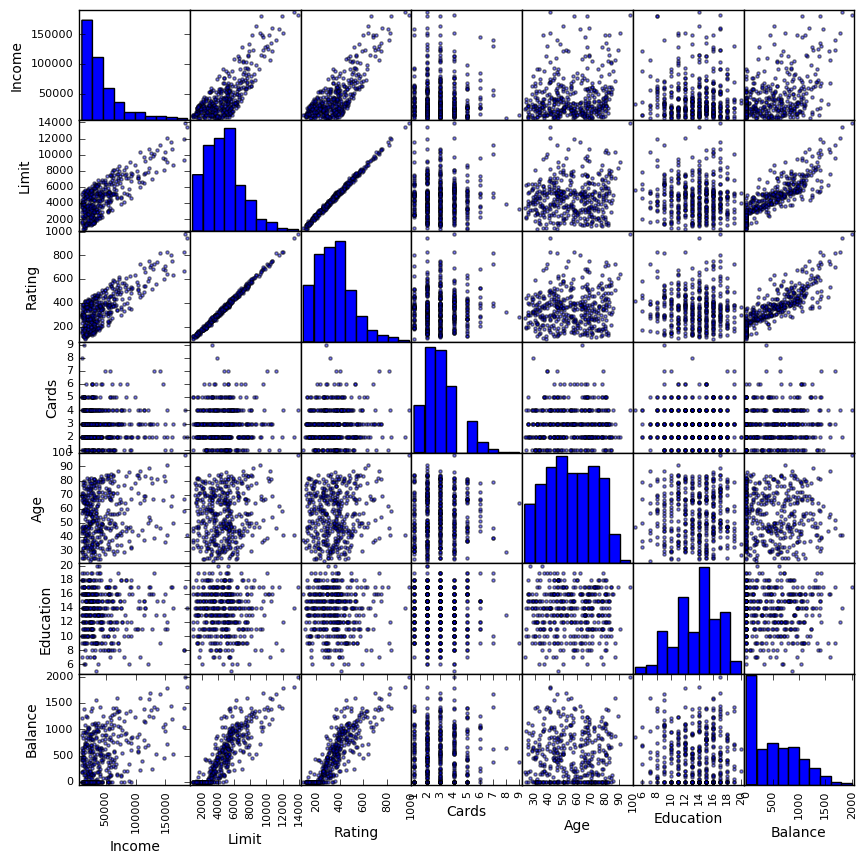

In [10]:
print(credit.corr())
pd.scatter_matrix(credit, figsize=(10, 10), diagonal='hist'); # trick: semi-colon prevents output

**Observations:**
1. Limit and Rating are highly correlated ($99.7\%$)  
+ Income strongly correlates with Limit ($79\%$) and Rating ($79\%$)
+ Balance correlates with Limit ($86\%$) and Rating ($86\%$)
+ There are "weird stripes" in some of the data. Why? 
+ Categorical information doesn't appear in this plot. Why? How can I visualize the categorical variables?

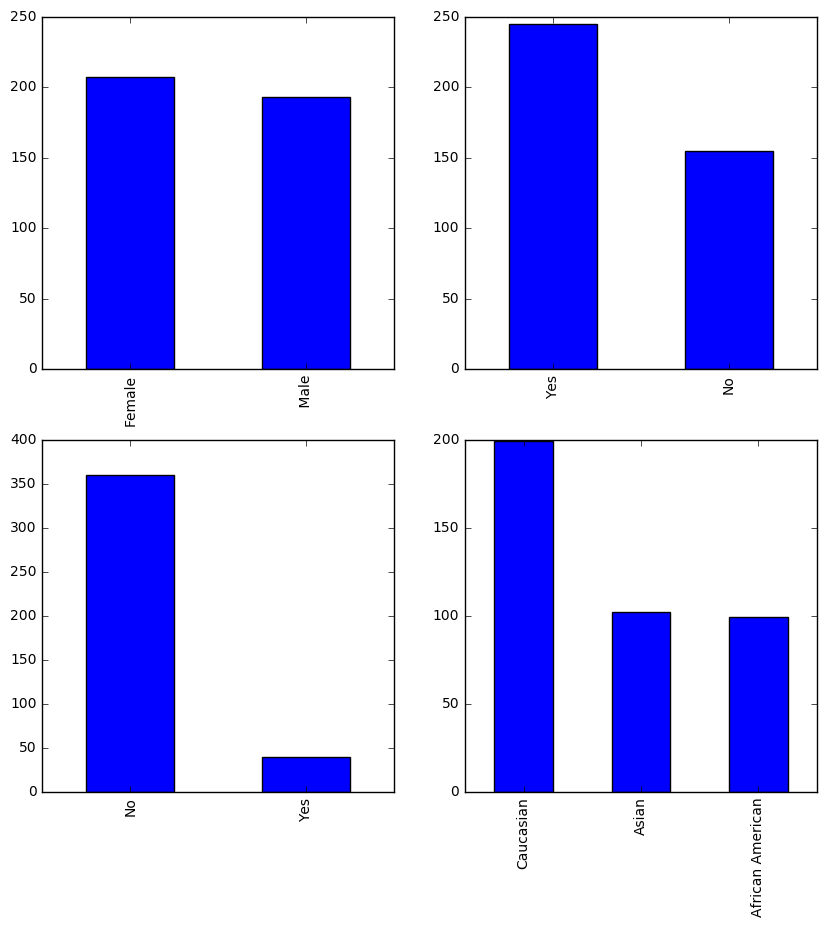

In [13]:
# Plot Categorical variables: Gender, Student, Married, Ethnicity
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
credit["Gender"].value_counts().plot(kind='bar',ax=axes[0,0]);
credit["Student"].value_counts().plot(kind='bar',ax=axes[1,0]);
credit["Married"].value_counts().plot(kind='bar',ax=axes[0,1]);
credit["Ethnicity"].value_counts().plot(kind='bar',ax=axes[1,1]);

## A first regression model

We regress first regress Limit on Rating: 
$$
\text{Limit} = \beta_0 + \beta_1 \text{Rating}. 
$$
Since credit ratings are primiarily used by banks to determine credit limits, we expect that Rating is very predictive for Limit, so this regression should be very good. 

We use the 'ols' function from the statsmodels python library. 


In [14]:
model = sm.ols(formula="Limit ~ Rating", data=credit)
model_result = model.fit()
print(model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Limit   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 6.348e+04
Date:                Fri, 23 Sep 2016   Prob (F-statistic):               0.00
Time:                        15:19:55   Log-Likelihood:                -2649.1
No. Observations:                 400   AIC:                             5302.
Df Residuals:                     398   BIC:                             5310.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -542.9282     22.850    -23.760      0.0

As we might have expected, the credit limit is almost entirely predicted by credit rating in this dataset.

Since Rating and Limit are almost the same variable, next we'll forget about Limit and just try to predict Rating from the real-valued variables (non-categorical variables): Income, Cards, Age, Education, Balance. 

**Exercise:** Develop a multilinear regression model to predict Rating. 
Interpret the results

In [25]:
# your code here 
model = sm.ols(formula="Rating ~ Income + Balance", data=credit)
model_result = model.fit()
print(model_result.summary())



                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     3140.
Date:                Fri, 23 Sep 2016   Prob (F-statistic):          4.70e-244
Time:                        15:28:22   Log-Likelihood:                -2019.2
No. Observations:                 400   AIC:                             4044.
Df Residuals:                     397   BIC:                             4056.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    145.3506      3.285     44.249      0.0

Which independent variables are good/bad predictors? 

**Observations:**

1. ... 
+ ...

## Incorporating categorical variables into regression models

We have four categorical variables (Gender, Student, Married, Ethnicity). How can we include them in a regression model? 

Let's start with a categorical variable with only 2 categories: Gender (Male, Female).

Idea: Create a "dummy variable" that turns Gender into a real value: 
$$
\text{Gender_num}_i = \begin{cases} 
1 & \text{if $i$-th person is female} \\
0 & \text{if $i$-th person is male}
\end{cases}. 
$$
Then we could try the model 
$$
\text{Balance} = \beta_0 + \beta_1 \text{Gender_num}. 
$$

In [37]:
credit["Gender_num"] = credit["Gender"].map({' Male':0, 'Female':1})
credit["Student_num"] = credit["Student"].map({'Yes':1, 'No':0})
credit["Married_num"] = credit["Married"].map({'Yes':1, 'No':0})

model = sm.ols(formula="Balance ~ Student_num + Income", data=credit)
model_result = model.fit()
print(model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     76.22
Date:                Fri, 23 Sep 2016   Prob (F-statistic):           9.64e-29
Time:                        15:46:03   Log-Likelihood:                -2954.4
No. Observations:                 400   AIC:                             5915.
Df Residuals:                     397   BIC:                             5927.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     211.1430     32.457      6.505      

Since the $p$-value for the Gender_num coefficient is very large, we conclude that there is no support for the conclusion that there is a difference in credit card balance between genders.

**Exercise**: Try to find a meaningful relationship in the data, for example, age vs. education, gender vs. married, etc...

In [38]:
# your code here 


## What about a categorical variable with 3 categories? 

The Ethnicity variable takes three values: Caucasian, Asian, and African American. 

What's wrong with the following?  
$$
\text{Ethnicity_num}_i = \begin{cases} 
0 & \text{if $i$-th person is Caucasian} \\
1 & \text{if $i$-th person is Asian} \\ 
2 & \text{if $i$-th person is African American}
\end{cases}. 
$$

Hint: Recall Nominal, Ordinal, Interval, Ratio variable types from Lecture 2

We'll need more than one dummy variable:  
$$
\text{Asian}_i = \begin{cases} 
1 & \text{if $i$-th person is Asian} \\
0 & \text{otherwise}
\end{cases}. 
$$
$$
\text{Caucasian}_i = \begin{cases} 
1 & \text{if $i$-th person is Caucasian} \\
0 & \text{otherwise}
\end{cases}. 
$$
The value with no dummy variable--African American--is called the *baseline*.

**Exercise**: Can you find a relationship in the data involving the variable ethnicity? 

In [39]:
credit["Asian_num"] = credit["Ethnicity"].map({'Caucasian':0, 'Asian':1, 'African American':0})
credit["Caucasian_num"] = credit["Ethnicity"].map({'Caucasian':1, 'Asian':0, 'African American':0})

In [40]:
# your code here 
model = sm.ols(formula="Balance ~ Caucasian_num", data=credit)
model_result = model.fit()
print(model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.004304
Date:                Fri, 23 Sep 2016   Prob (F-statistic):              0.948
Time:                        15:46:42   Log-Likelihood:                -3019.4
No. Observations:                 400   AIC:                             6043.
Df Residuals:                     398   BIC:                             6051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       521.5174     32.469     16.062